Preciso separar em 10 e 20Nm pq se deixar os dois juntos os Limites de Controles ficam gigantes, e da um erro absurdo

# Imports

In [1]:
import pandas as pd 
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [2]:
from funcoes_module import rms, pk_pk, kurtosis, crest_factor, skewness, shape_factor, std_value, min_value, max_value, mean_value

In [3]:
from funcoes_module import extract_info_from_filename, extract_and_format_dataframe, format_time, features_extract, features_timeframe,format_dataframe_basona ,extract_datasets_and_process_features,read_1file_datasets , combine_features_datasets 

In [4]:
from funcoes_module import plot_df,plot_df_features, compare_df_plots #,plot_health_non_health_features

In [5]:
from descricoes_SE import descricao_falha


In [6]:
fault_description = descricao_falha("gear_pitting",30)
print(fault_description)

Precisão do diagnóstico: 63 % 

Falha Identificada: Desgaste por Corrosão
Descrição:
A falha do tipo gear pitting se dá devido a ...blablablagear_wear_img.pngCausa Provável/Ações Corretivas: 30%


base de features

In [7]:
df_features_org = combine_features_datasets("todos","inicial",0.1) #treino,teste,todos ; inicial,final ; timeframe

Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

### Visualizando  correlação entre as variáveis
remover variáveis com correlação muito alta entre si

In [8]:
# df_x = df_features_resposta.select_dtypes(include=['float64', 'int64'])
# correlation_matrix = abs(df_x.corr())

# # Plotar o mapa de calor da correlação
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
# plt.title('Heatmap of Correlation between Numeric Values')
# plt.show()

Remoção das features irrelevantes das top 15
7 removidas, 8 restantes

In [9]:
# k=1
# for i in df_x.columns:
#         print(f'{k}. {i}') 
#         k=k+1

#df_x.columns[(5)-1] # x.std e x.rms tem correlação 1!!!! por isso não muda nada no meu sistema
# z kurtosis tem 0.95 com z.shape_factor por isso não muda nada
# z rms tb pode ser removido e deixar só z.std
# x crest factor tem 0.84 com x kurtosis
redundant_ft_drop_list = ['gearbox_vibration_x.rms','gearbox_vibration_z.kurtosis','gearbox_vibration_z.rms','gearbox_vibration_x.crest_factor','gearbox_vibration_x.min','gearbox_vibration_x.pk_pk','Input Torque.mean']
df_features_org = df_features_org.drop(columns=redundant_ft_drop_list)


## Funções Formatação

In [10]:
#### #### Funções Formatação #### ####
def normalize_data(dataframe):
    scaler = MinMaxScaler() 
    # Selecting numerical columns in the DataFrame
    numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #normalized_df =dataframe.copy()
    # Fitting the scaler and transforming the data
    dataframe[numerical_cols] = scaler.fit_transform(dataframe[numerical_cols])
    return dataframe

def fault_to_binary(df_features):
    if not ((df_features['Fault'] == 0) | (df_features['Fault'] == 1)).all(): #condição para não dar ruim se aplicar 2x a função
        df_features['Fault'] = df_features['Fault'].apply(lambda x: 0 if x == 'health' else 1)
    #df_features['Fault'].value_counts()
    return df_features

def top_features_list(df_features, num_features):
    # Select numeric types from the DataFrame
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault'])
    
    # Drop the 'Fault' column from the series to avoid self-correlation
    top_features = top_features.drop('Fault', axis=0)
    
    # Get the 'num_features' largest values
    largest_features = top_features.nlargest(num_features)
    
    # Return the index of the largest features as a list
    features_chosen = largest_features.index.tolist()
    return features_chosen

def filter_top_features_df(df_features,top_features):    
    filtered_columns = top_features + ['Fault','Torque']#,'Degree']
    df_features = df_features[filtered_columns]
    return df_features

def format_dataframe_features(df_features_org,number_of_features):

    normalized_dataframe = normalize_data(df_features_org)
    binary_fault_dataframe = fault_to_binary(normalized_dataframe)

    top_ft_list = top_features_list(binary_fault_dataframe,number_of_features)

    df_top_features = filter_top_features_df(binary_fault_dataframe,top_ft_list)
    return df_top_features,binary_fault_dataframe

In [49]:
#df_features_org['Fault'].value_counts()
normalized_dataframe = normalize_data(df_features_org)
normalized_dataframe['Fault'].value_counts()
binary_fault_dataframe = fault_to_binary(normalized_dataframe)
binary_fault_dataframe['Fault'].value_counts()
#top_ft_list = top_features_list(binary_fault_dataframe,10)
top_ft_list = top_features_list(binary_fault_dataframe,10)
top_ft_list
#df_top_features = filter_top_features_df(binary_fault_dataframe,top_ft_list)
df_top_features = filter_top_features_df(binary_fault_dataframe,top_ft_list)
df_top_features

respostas_df,df_features_resposta  = apply_rules(df_top_features,"20Nm")

In [51]:
respostas_df

,gearbox_vibration_x.shape_factor,gearbox_vibration_x.std,gearbox_vibration_z.shape_factor,gearbox_vibration_x.kurtosis,gearbox_vibration_x.skewness,gearbox_vibration_z.std,Input Torque.min,gearbox_vibration_x.max,Input Torque.max,gearbox_vibration_z.crest_factor,Resposta SE
80,False,False,False,True,False,False,False,False,False,True,not health
81,False,False,True,False,False,False,False,False,False,True,not health
82,False,False,True,True,False,False,False,False,False,True,not health
83,False,False,True,True,False,False,False,False,False,True,not health
84,False,False,True,True,False,False,False,False,False,True,not health
...,...,...,...,...,...,...,...,...,...,...,...
2155,False,False,False,False,False,False,False,True,False,True,not health
2156,False,False,False,False,False,False,False,False,False,False,not health
2157,False,False,False,False,False,False,False,False,False,False,not health
2158,False,False,False,False,False,False,False,True,False,True,not health


## Funções SE

In [11]:
#### divisão da apply_rules
def apply_bounds_treino(df_features,torque): # (df_top_features , 20Nm)
    df_features_torque = df_features[df_features['Torque'] == torque]

    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault']).drop('Fault', axis=0)

    #Criando dicionário com as features:bounds
    features_h_bounds = {}
    for ft in top_features.index: # vai criar o dicionário no formato {feature_name:[lower_bound,upper_bound],...}
        features_h_bounds[ft] = [health_data[ft].min(),health_data[ft].max()] #ft1

    # Criando respostas do SE baseado nos bounds
    return features_h_bounds


def apply_regras_teste(df_features,df_features_t,torque): #(df_top_features,df_top_features_t , 20Nm)
    
    df_features_torque_t = df_features_t[df_features_t['Torque'] == torque]
    
    features_h_bounds = apply_bounds_treino(df_features,torque) #extraindo limites treino
    

    respostas_t = {} # dicionário para armazenar respostas(está dentro da faixa?)
    for ft in features_h_bounds:
        respostas_t[ft] = (features_h_bounds[ft][0] <= df_features_torque_t[ft]) & (df_features_torque_t[ft] <= features_h_bounds[ft][1])
    # respotas = {ft1:True,ft2:False,...} -- True = dentro dos intervalo de controle de todas features (health)
    
    respostas_df_t = pd.DataFrame(respostas_t)
    df_features_respostas_t = df_features_torque_t
    df_features_respostas_t['Resposta SE'] = respostas_df_t.all(axis=1).apply(lambda x: 'health' if x else 'not health') # se algum true = health
    respostas_df_t['Resposta SE'] = respostas_df_t.all(axis=1).apply(lambda x: 'health' if x else 'not health')

    # transformando 0 e 1 em health e non health 
    df_features_respostas_t['Fault'] = df_features_respostas_t['Fault'].map({0: 'health', 1: 'not health'}) #transformando

    return respostas_df_t, df_features_respostas_t


In [48]:
#### #### Funções SE #### ####
def apply_rules(df_features,torque): # (df_top_features , 20Nm)
    df_features_torque = df_features[df_features['Torque'] == torque]

    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault']).drop('Fault', axis=0)

    #Criando dicionário com as features:bounds
    features_h_bounds = {}
    for ft in top_features.index: # vai criar o dicionário no formato {feature_name:[lower_bound,upper_bound],...}
        features_h_bounds[ft] = [health_data[ft].min(),health_data[ft].max()] #ft1

    # Criando respostas do SE baseado nos bounds
    
    respostas = {} # dicionário para armazenar respostas(está dentro da faixa?)
    for ft in features_h_bounds:
        respostas[ft] = (features_h_bounds[ft][0] <= df_features_torque[ft]) & (df_features_torque[ft] <= features_h_bounds[ft][1])
    # respotas = {ft1:True,ft2:False,...} -- True = dentro dos intervalo de controle de todas features (health)

    respostas_df = pd.DataFrame(respostas)
    df_features_respostas = df_features_torque
    df_features_respostas['Resposta SE'] = respostas_df.all(axis=1).apply(lambda x: 'health' if x else 'not health') # se algum true = health
    respostas_df['Resposta SE'] = respostas_df.all(axis=1).apply(lambda x: 'health' if x else 'not health')

    # transformando 0 e 1 em health e non health 
    df_features_respostas['Fault'] = df_features_respostas['Fault'].map({0: 'health', 1: 'not health'}) #transformando

    return respostas_df, df_features_respostas


def print_result(df_resultado): #df_features_resposta
    print(f"Resposta correta :{df_resultado['Fault'].value_counts()}\n")

    print(df_resultado['Resposta SE'].value_counts())


### Plot Matriz de Confusão com comparação ### 
from PIL import Image
def plot_cm_didatica(features_resposta):
    img = Image.open('Confusion-matrix-terminology.png')  # Replace 'path_to_your_image.jpg' with the actual file path

    # Create a 2x1 subplot matrix
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

    true_labels = features_resposta['Fault']
    predicted_labels = features_resposta['Resposta SE']

    # Compute the confusion matrix
    cm_1 = confusion_matrix(true_labels, predicted_labels, labels=['health', 'not health'])

    # Plot the confusion matrix in the first subplot
    sns.heatmap(cm_1, annot=True, fmt='d', cmap='Blues', xticklabels=['health', 'not health'], yticklabels=['health', 'not health'], ax=ax[0])
    ax[0].set_xlabel('Classe Predita')
    ax[0].set_ylabel('Classe Real')
    ax[0].set_title('Matriz de Confusão')

    # Display the image in the second subplot
    ax[1].imshow(img)
    ax[1].axis('off')  # Turn off axis to hide ticks
    #ax[1].set_title('Your Image')

    plt.tight_layout()  # Adjust subplots to fit into figure area.
    plt.show()
    
    #definição top_features
    # Select numeric types from the DataFrame
    df_features_n = features_resposta.select_dtypes(include=['float64', 'int64']) #selecionar as colunas da feature respostas que são numéricas: colunas de features

    
    accuracy = np.trace(cm_1) / np.sum(cm_1)
    print(cm_1)
    print(f'Accuracy: {accuracy:.2%} para {len(df_features_n.columns)} features analisadas')
    print('Acurácia = resultados corretos/total (TN+TP)/(TN+TP+FN+FP)')


In [13]:
normalized_dataframe = normalize_data(df_features_org)
binary_fault_dataframe = fault_to_binary(normalized_dataframe)
top_3ft_list = top_features_list(binary_fault_dataframe,3)

In [39]:
binary_fault_dataframe['Fault'].value_counts()

Fault
1.0    2000
0.0     160
Name: count, dtype: int64

## Funções Plots

### Histograma

In [14]:
def plot_health_non_health_features(df_features, torque):
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features[df_features['Torque'] == torque]

    # Separate the data into healthy and non-healthy based on the 'Fault' column
    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    non_health_data = df_features_torque[df_features_torque['Fault'] != 0]

    # List of feature columns to plot, excluding non-numeric or specific columns
    features = df_features_torque.columns.drop(['Fault', 'Torque'])

    # Calculate the number of features and determine the number of rows and columns for the subplots
    n_features = len(features)
    n_cols = int(np.ceil(np.sqrt(n_features)))
    n_rows = int(np.ceil(n_features / n_cols))

    # Create subplots grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array to easily index it with a single loop

    # Plot histograms for each feature in the grid
    for i, feature in enumerate(features):
        bins = 30
        axs[i].hist(health_data[feature], bins, alpha=0.5, label='health', color='lime')
        axs[i].hist(non_health_data[feature], bins, alpha=0.5, label='non-health', color='royalblue')

        # Calculate the mean for health_data
        mean_value = health_data[feature].mean()
        
        # Bounds
        upper_bound = health_data[feature].max()
        lower_bound = health_data[feature].min()

        # Draw a green vertical line at the mean
        axs[i].axvline(mean_value, color='green', linestyle='dashed', linewidth=1, label='Health Mean')
        
        # Draw upper and lower bound lines 
        axs[i].axvline(upper_bound, color='darkgreen', linestyle='solid', linewidth=1, label='Upper Bound')
        axs[i].axvline(lower_bound, color='darkgreen', linestyle='solid', linewidth=1, label='Lower Bound')

        axs[i].legend(loc='upper right')
        axs[i].set_title(f'{feature} {torque}')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Frequency')

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage:
# plot_health_non_health_features(df_top_features, "20Nm")

### Scatter plot

In [15]:
def plot_health_non_health_scatter(df_features, torque):
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features[df_features['Torque'] == torque]

    # Separate the data into healthy and non-healthy based on the 'Fault' column
    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    non_health_data = df_features_torque[df_features_torque['Fault'] != 0]

    # List of feature columns to plot, excluding non-numeric or specific columns
    features = df_features_torque.columns.drop(['Fault', 'Torque'])

    # Calculate the number of features and determine the number of rows and columns for the subplots
    n_features = len(features)
    n_cols = int(np.ceil(np.sqrt(n_features)))
    n_rows = int(np.ceil(n_features / n_cols))

    # Create subplots grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array to easily index it with a single loop

    # Plot scatter for each feature in the grid
    for i, feature in enumerate(features):
        axs[i].scatter(health_data[feature], health_data['Torque'], alpha=0.5, label='Health', color='lime')
        axs[i].scatter(non_health_data[feature], non_health_data['Torque'], alpha=0.5, label='Damaged', color='royalblue')
        axs[i].legend(loc='upper right')
        axs[i].set_title(f'{feature} {torque}')
        axs[i].set_xlabel(feature)
        axs[i].set_ylabel('Torque')

        # Bounds
        upper_bound = health_data[feature].max()
        lower_bound = health_data[feature].min()
        # Draw upper and lower bound lines 
        axs[i].axvline(upper_bound, color='darkgreen', linestyle='solid', linewidth=1, label='Upper Bound')
        axs[i].axvline(lower_bound, color='darkgreen', linestyle='solid', linewidth=1, label='Lower Bound')
            
    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage:
# plot_health_non_health_scatter(df_top_features, "20Nm")

### Kernel Density Estimate (KDE)

In [16]:
def plot_health_non_health_kde(df_features, torque):
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features[df_features['Torque'] == torque]

    # Separate the data into healthy and non-healthy based on the 'Fault' column
    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    non_health_data = df_features_torque[df_features_torque['Fault'] != 0]

    # List of feature columns to plot, excluding non-numeric or specific columns
    features = df_features_torque.columns.drop(['Fault', 'Torque'])

    # Calculate the number of features and determine the number of rows and columns for the subplots
    n_features = len(features)
    n_cols = int(np.ceil(np.sqrt(n_features)))
    n_rows = int(np.ceil(n_features / n_cols))

    # Create subplots grid
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))  # Adjust figsize accordingly
    axs = axs.flatten()  # Flatten the array to easily index it with a single loop

    # Plot KDE for each feature in the grid
    for i, feature in enumerate(features):
        sns.kdeplot(health_data[feature], ax=axs[i], fill=True, alpha=0.5, label='Health', color='lime')
        sns.kdeplot(non_health_data[feature], ax=axs[i], fill=True, alpha=0.5, label='Damaged', color='royalblue')
        axs[i].legend(loc='upper right')
        axs[i].set_title(f'{feature} {torque}')
        axs[i].set_xlabel(feature)

        # Bounds
        upper_bound = health_data[feature].max()
        lower_bound = health_data[feature].min()
        # Draw upper and lower bound lines 
        axs[i].axvline(upper_bound, color='darkgreen', linestyle='solid', linewidth=1, label='Upper Bound')
        axs[i].axvline(lower_bound, color='darkgreen', linestyle='solid', linewidth=1, label='Lower Bound')

    # Turn off unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage:
# plot_health_non_health_kde(df_top_features, "20Nm")

### Pair Plot
- É ESSE!
- Esse é muito muito bom para eu criar minhas regras, pegando 2 variáveis eu já consigo ver os pontos que o health estão clusterizados

In [17]:
def plot_health_non_health_pairplot(df_features):#, torque):
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features#[df_features['Torque'] == torque]

    # Separate the data into healthy and non-healthy based on the 'Fault' column
    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    non_health_data = df_features_torque[df_features_torque['Fault'] != 0]

    # Combine both datasets into one with an additional label column to differentiate between health states
    health_data['Condition'] = 'Health'
    non_health_data['Condition'] = 'Damaged'
    combined_data = pd.concat([health_data, non_health_data])

    # Drop the 'Torque' column if it's not needed for pair plotting
    combined_data = combined_data.drop(['Torque'], axis=1)

    # Use seaborn's pairplot to create a grid of scatter plots for each pair of features
    pair_plot = sns.pairplot(combined_data, hue='Condition', palette={'Health': 'lime', 'Damaged': 'royalblue'}, 
                             vars=combined_data.columns.drop(['Fault', 'Condition']))
    
    pair_plot.fig.suptitle('Pair Plot of Features at ' "+ torque", y=1.02)  # Title and adjust title position
    plt.show()

# Example call with example data
#plot_health_non_health_pairplot(df_top_features)#, "20Nm")

### 3D top 3 features

In [18]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def plot_3d_health_non_health(df_features, torque,top_3ft): # df_top_features,"20Nm",top_3ft_list
    # Filter the dataframe based on 'Torque' value
    df_features_torque = df_features[df_features['Torque'] == torque]

    # Separate the data into healthy and non-healthy based on the 'Fault' column
    health_data = df_features_torque[df_features_torque['Fault'] == 0]
    non_health_data = df_features_torque[df_features_torque['Fault'] != 0]

    # Create a new figure for 3D plotting
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    var1 = top_3ft[0]
    var2 = top_3ft[1]
    var3 = top_3ft[2]

    # Plotting the healthy data points
    ax.scatter(health_data[var1], health_data[var2], health_data[var3], color='lime', label='Health')

    # Plotting the non-healthy data points
    ax.scatter(non_health_data[var1], non_health_data[var2], non_health_data[var3], color='royalblue', label='Damaged')

    # Setting the labels for each axis
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_zlabel(var3)

    # Title and legend
    ax.set_title('3D Plot of ' + var1 + ', ' + var2 + ', ' + var3 + ' at ' + torque)
    ax.legend()

    plt.show()

# Example call with example data
#plot_3d_health_non_health(df_top_features, "10Nm", top_3ft_list)


## funcao para visualizar correlações

In [19]:
def corr_ciclo1(df_features_c1):
    #   visualizando datasets de 10 e 20Nm
    df_features_c1_num_10Nm = df_features_c1[df_features_c1['Torque']=="10Nm"]
    # print("10Nm")
    # print(df_features_c1_num_10Nm['Fault'].value_counts())
    df_features_c1_num_20Nm = df_features_c1[df_features_c1['Torque']=="20Nm"]
    # print("20Nm")
    # print(df_features_c1_num_20Nm['Fault'].value_counts())

    #Analisando correlações de cada um desses 
    #extraindo floats
    df_features_c1_num_10Nm= df_features_c1_num_10Nm.select_dtypes(include=['float64','int64'])
    df_features_c1_num_20Nm= df_features_c1_num_20Nm.select_dtypes(include=['float64','int64'])
    df_features_c1_num= df_features_c1.select_dtypes(include=['float64','int64'])
    # array de coeficientes de correlação:
    df_features_c1_cor_10Nm = abs(df_features_c1_num_10Nm.corr()['Fault']).drop('Fault', axis=0)
    df_features_c1_cor_20Nm = abs(df_features_c1_num_20Nm.corr()['Fault']).drop('Fault', axis=0)
    df_features_c1_cor = abs(df_features_c1_num.corr()['Fault']).drop('Fault', axis=0)

    # adicionando a um dataframe
    df_cor_c1 = pd.DataFrame()
    df_cor_c1['10Nm']=df_features_c1_cor_10Nm
    df_cor_c1['20Nm']=df_features_c1_cor_20Nm
    df_cor_c1['total']=df_features_c1_cor
    #df_sorted = df_cor_c1.sort_values(by='10Nm', ascending=False)
    #df_sorted
    return df_cor_c1

def analyse_corr_dif_torque(df_cor_c1,torque_prioritario,num_features):
    #df_cor_c1.drop('Fault',axis=0,inplace=True)
    df_cor_c1['difference']=abs(df_cor_c1['10Nm']-df_cor_c1['20Nm'])
    df_cor_c1 = df_cor_c1.sort_values(by='difference',ascending=False).nlargest(num_features,torque_prioritario) #'10Nm
    return df_cor_c1

# Rodando as funções
### **Variáveis relevantes:**
  1. df_features_org = dataframe original (basona) - 40 features + 5 labels
   
  2. binary_fault_dataframe = dataframe completo normalizado e binário
   
  3. df_top_features = dataframe normalizado e binário com as 'n' features  filtradas
   
  4. df_features_resposta = dataframe normalizado, binário removido, com 'n' features  filtradas e nova coluna 'Resposta SE' classificando  entre health e not health
     * df_features_resposta é input para a confusion matrix

## Rodando Funções Formatação e SE

 * gerando df_features_resposta 

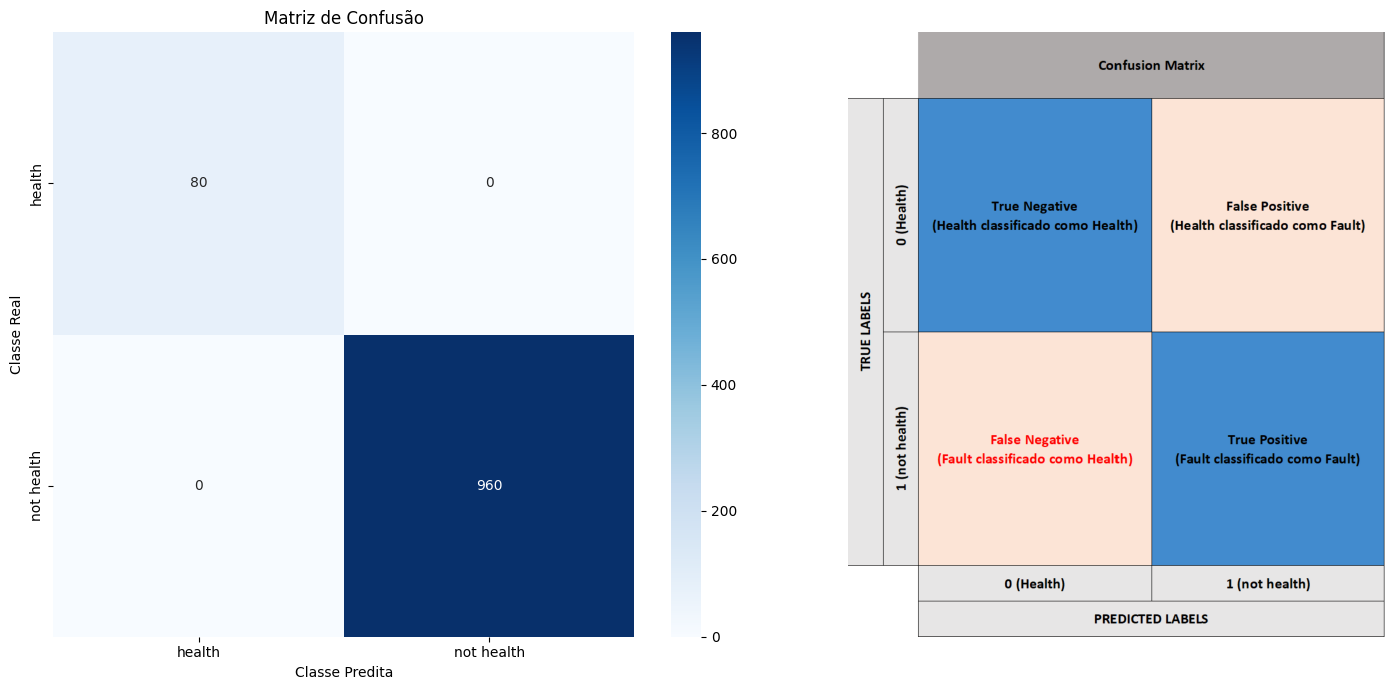

[[ 80   0]
 [  0 960]]
Accuracy: 100.00% para 15 features analisadas
Acurácia = resultados corretos/total (TN+TP)/(TN+TP+FN+FP)


In [20]:
def gerar_features_resposta_treino(n_features):
    df_top_features,binary_fault_dataframe = format_dataframe_features(df_features_org,n_features)
    #### #### Sistema  Especialista #### ####
    respostas_df,df_features_resposta  = apply_rules(df_top_features,"20Nm")
    # df_features_resposta = Da a resposta do sistema especialista "pred"
    return df_features_resposta 
df_features_resposta= gerar_features_resposta_treino(15)
cm_plot_didatico = plot_cm_didatica(df_features_resposta) # confusion matrix com imagem ilustrativa 

## Funções Plots

In [21]:
#### #### Plots #### ####


# Plotagem histograma com limites de controle max_min health
plot_health_non_health_features(df_top_features,"20Nm")

# Plotagem scatter_plot com limites de controle max_min health
plot_health_non_health_scatter(df_top_features,"20Nm")

# Plotagem Kernel Density Estimate(KDE) com limites de controle max_min health
plot_health_non_health_kde(df_top_features, "20Nm")

## Plotagem Pair Plot ## visualização das relações 2-2 entre features
plot_health_non_health_pairplot(df_top_features)#, "20Nm")
        # gráfico ajustado entre 10/20 ou todos

# Plot 3D 3 features, talvez seja bonito colocar no relatório
plot_3d_health_non_health(df_top_features, "10Nm", top_3ft_list)


'\n\n# Plotagem histograma com limites de controle max_min health\nplot_health_non_health_features(df_top_features,"20Nm")\n\n# Plotagem scatter_plot com limites de controle max_min health\nplot_health_non_health_scatter(df_top_features,"20Nm")\n\n# Plotagem Kernel Density Estimate(KDE) com limites de controle max_min health\nplot_health_non_health_kde(df_top_features, "20Nm")\n\n## Plotagem Pair Plot ## visualização das relações 2-2 entre features\nplot_health_non_health_pairplot(df_top_features)#, "20Nm")\n        # gráfico ajustado entre 10/20 ou todos\n\n# Plot 3D 3 features, talvez seja bonito colocar no relatório\nplot_3d_health_non_health(df_top_features, "10Nm", top_3ft_list)\n'

# Plotar tabela de acurácia / feature
dentro de funções


In [22]:
# Define a function that encapsulates the recurring process
def compute_accuracy(df_features_org, num_features, torque_setting): #aqui ta pedindo a df_ft_org

    df_top_features,binary_fault_dataframe = format_dataframe_features(df_features_org,num_features)
    respostas_df, df_features_resposta = apply_rules(df_top_features, torque_setting) #aqui vai transformar a org em df_ft_rsp

    true_labels = df_features_resposta['Fault']
    predicted_labels = df_features_resposta['Resposta SE']

    # Compute the confusion matrix and accuracy
    cm = confusion_matrix(true_labels, predicted_labels, labels=['health', 'not health'])
    accuracy = np.trace(cm) / np.sum(cm)
    return accuracy

def plot_accuracy(df_features_org,num_features):
    # List the number of features you want to test, e.g., 1 to 5
    # Select numeric types from the DataFrame
    df_features_n = df_features_resposta.select_dtypes(include=['float64', 'int64']) #selecionar as colunas da feature respostas que são numéricas: colunas de features
    num_features_list = range(1,num_features+1)  # You can adjust this range as needed

    accuracies = {}
    list_features= []
    list_20Nm_accuracy = []
    list_10Nm_accuracy = []
    # Iterate over each number of features
    for num_features in num_features_list:
    # Compute accuracies for each torque setting
        accuracy_10Nm = compute_accuracy(df_features_org, num_features, "10Nm")
        accuracy_20Nm = compute_accuracy(df_features_org, num_features, "20Nm")
        # Append results to list
        list_features.append(num_features)
        list_10Nm_accuracy.append(accuracy_10Nm)
        list_20Nm_accuracy.append(accuracy_20Nm)

    # Append list to dicionary
    accuracies['Num_Features'] = list_features
    accuracies['10Nm_Accuracy']= list_10Nm_accuracy
    accuracies['20Nm_Accuracy']= list_20Nm_accuracy
    # print (num_features_list)
    # print(accuracy_10Nm)
    # accuracies
    #list_10Nm_accuracy
    # Convert dictionary to DataFrame
    accuracy_df = pd.DataFrame(accuracies)
    return accuracy_df


In [23]:
ciclo1_accuracy = plot_accuracy(df_features_org,15)
ciclo1_accuracy

,Num_Features,10Nm_Accuracy,20Nm_Accuracy
0,1,0.514286,0.475962
1,2,0.826786,0.824038
2,3,0.840179,0.832692
3,4,0.840179,0.832692
4,5,0.898214,0.919231
5,6,0.923214,0.928846
6,7,1.000000,1.000000
7,8,1.000000,1.000000
8,9,1.000000,1.000000
9,10,1.000000,1.000000


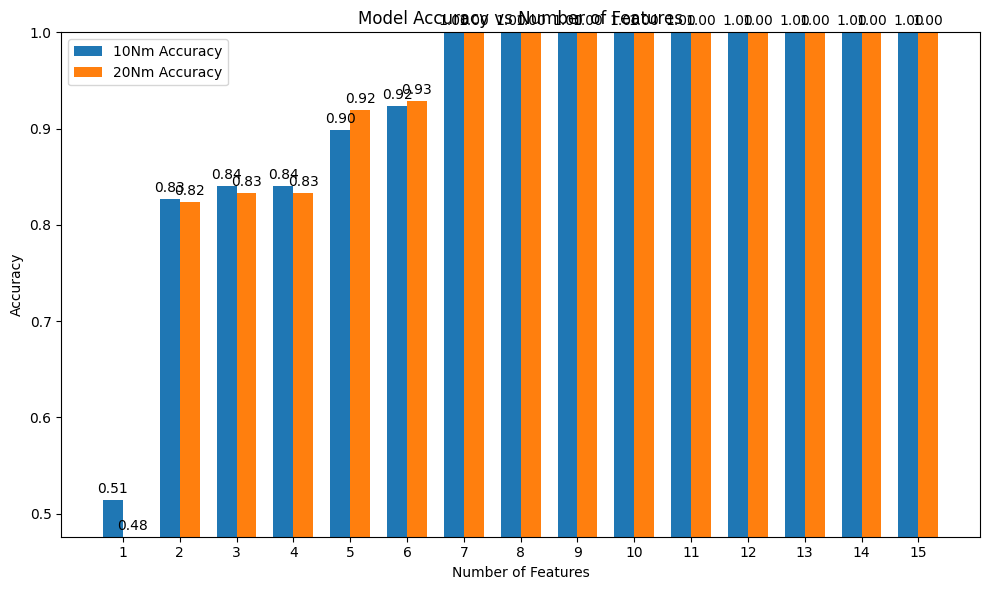

In [24]:
# Plotting
x = np.arange(len(ciclo1_accuracy['Num_Features']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, ciclo1_accuracy['10Nm_Accuracy'], width, label='10Nm Accuracy')
rects2 = ax.bar(x + width/2, ciclo1_accuracy['20Nm_Accuracy'], width, label='20Nm Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Number of Features')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy vs Number of Features')
ax.set_xticks(x)
ax.set_xticklabels(ciclo1_accuracy['Num_Features'])
ax.legend()

# Adding bar labels with 2 decimal places
ax.bar_label(rects1, padding=3, fmt='%.2f')
ax.bar_label(rects2, padding=3, fmt='%.2f')

fig.tight_layout()
plt.ylim(min(ciclo1_accuracy['10Nm_Accuracy'].min(), ciclo1_accuracy['20Nm_Accuracy'].min()), 1)
plt.show()


Features relevantes: (8 features)
- 1,2,3,4,7,10,11,14


# Resultados  Treinamento
- Usar 14 features, ele vai conseguir classificar tudo que é health e o resto é não health, 100% de acerto
  - Testar no conjunto de teste 

- Se eu for querer inverter as coisas, vai ficar mais difícil aumentar a precisão, inclusive mais features vai ser pior por causa do overfitting e pa, mostrar as duas análises no meu relatório

é muito mais simples e preciso ir pela análise 1: que me da 100% de acerto

Se ela me da 100% de acerto não preciso fazer o outro método ne kkkkk.
**Se ela não der 100% de acerto, no teste, ai faço o outro método.**

# Executar Conjunto de Teste

Estratégia: 
1. Mapear funções que vou usar
2. Puxar função 1 a 1 e mudar a referência do df_org para o df_teste
   1. Isso vou ter q mexer no apply rules se não me engano, generalizar mais ela
3. Ver se alguma função intermediária que não ta genérica e vai quebrar a parada
4. Pular as funções de análise de variáveis do treino, você só quer plotar os resultados
5. Executar e armazenar resultados

In [25]:
# Importando e criando basona teste
df_features_org_t = combine_features_datasets("todos","final",0.1) #treino,teste,todos ; inicial,final ; timeframe
df_features_org_t = df_features_org_t.drop(columns=redundant_ft_drop_list)

Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

Observações:
- não vou usar .corr() para relacionar features, vou filtrar as mesmas to treino

In [26]:
# Salvando as variáveis treino
#### #### formatação #### ####
def gerar_features_resposta_teste(n_features): 
    df_top_features,binary_fault_dataframe = format_dataframe_features(df_features_org,n_features)
    #### #### Sistema  Especialista #### ####
    respostas_df,df_features_resposta  = apply_rules(df_top_features,"20Nm")
    # Rodando funções Foco Teste ('_t')

    #### #### formatação #### #### 
    normalized_dataframe_t = normalize_data(df_features_org_t)
    binary_fault_dataframe_t = fault_to_binary(normalized_dataframe_t)
        # pegar features do treino
    top_ft_list = top_features_list(binary_fault_dataframe,n_features) #pegando as features do treino
        # aplicar features do treino no df teste
    df_top_features_t = filter_top_features_df(binary_fault_dataframe_t,top_ft_list)
    # ok até aqui
    #### #### Sistema  Especialista #### ####
    respostas_df_t,df_features_resposta_t  = apply_regras_teste(df_top_features,df_top_features_t,"20Nm")
 
    return df_features_resposta_t
df_features_resposta_t = gerar_features_resposta_teste(4)
#plot_cm_teste = plot_cm_didatica(df_features_resposta_t)
df_features_resposta_t

,gearbox_vibration_x.shape_factor,gearbox_vibration_x.std,gearbox_vibration_z.shape_factor,gearbox_vibration_x.kurtosis,Fault,Torque,Resposta SE
79,0.316864,0.500382,0.166261,0.249864,not health,20Nm,not health
80,0.202052,0.547468,0.098961,0.132205,not health,20Nm,not health
81,0.253032,0.505565,0.106745,0.194099,not health,20Nm,not health
82,0.233742,0.453448,0.120473,0.228370,not health,20Nm,not health
83,0.202647,0.551501,0.067101,0.142724,not health,20Nm,not health
...,...,...,...,...,...,...,...
2128,0.570190,0.674023,0.812610,0.832745,not health,20Nm,not health
2129,0.325524,0.638717,0.436137,0.324984,not health,20Nm,not health
2130,0.459635,0.670625,0.601545,0.566769,not health,20Nm,not health
2131,0.428210,0.674214,0.664765,0.359025,not health,20Nm,not health


# Fim Ciclo 1
## Resultados
- O sistema especialista com a maior precisão é o que classifca tudo como falha o tempo todo (14+)
- Não tem nenhuma utilidade kkkkkkkkk
- EU TENHO QUE PARAMETRIZAR A RELAÇÃO FALHA VS SAUDÁVEL
DEVIDO AO MEU SISTEMA TAR 4X MAIS FALHAS QUE SAUDÁVEIS, O RESULTADO MAIS OPTIMIZADO SEMPRE VAI SER O QUE A FALHA ACERTA, E FODASE O SAUDÁVEL

* O CORRETO SERIA CADA UMA DELAS TER PESO 50%
  * Além de 

# Evaluating the model correctly

# Mágica gpt, vmo ver

Function to calculate evaluation metrics

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

def plot_confusion_matrix(y_true, y_pred, labels):
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Classe Predita')
    ax.set_ylabel('Classe Real')
    ax.set_title('Matriz de Confusão')
    
    plt.tight_layout()
    plt.show()
    
    return cm

def calculate_metrics(y_true, y_pred,cm, labels):
    #cm = confusion_matrix(y_true, y_pred, labels=labels)
    accuracy = np.trace(cm) / np.sum(cm)
    precision = precision_score(y_true, y_pred, pos_label='health') #avaliar o correto
    recall = recall_score(y_true, y_pred, pos_label='health')
    f1 = f1_score(y_true, y_pred, pos_label='health')
    
    print(f'Accuracy: {accuracy:.2%}')
    print(f'Precision: {precision:.2%}')
    print(f'Recall: {recall:.2%}')
    print(f'F1 Score: {f1:.2%}')
    print(classification_report(y_true, y_pred, target_names=labels))

    return accuracy, precision, recall, f1

def plot_roc_curve(y_true, y_prob, pos_label):
    fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=pos_label)
    auc = roc_auc_score(y_true, y_prob)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def evaluate_model(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = plot_confusion_matrix(y_true, y_pred, labels)
    accuracy, precision, recall, f1 = calculate_metrics(y_true, y_pred,cm, labels)
    
    if 'Prob' in features_resposta.columns:  # Assuming you have probability scores
        y_prob = features_resposta['Prob']
        #plot_roc_curve(y_true, y_prob, pos_label='health')
    #else:
        #print("Probability scores not found in features_resposta DataFrame.")
    
    # Select numeric types from the DataFrame
    df_features_n = features_resposta.select_dtypes(include=['float64', 'int64']) #selecionar as colunas da feature respostas que são numéricas: colunas de features
    print(f'{len(df_features_n.columns)} features analisadas')
    
# Example usage
# Assuming features_resposta is your DataFrame

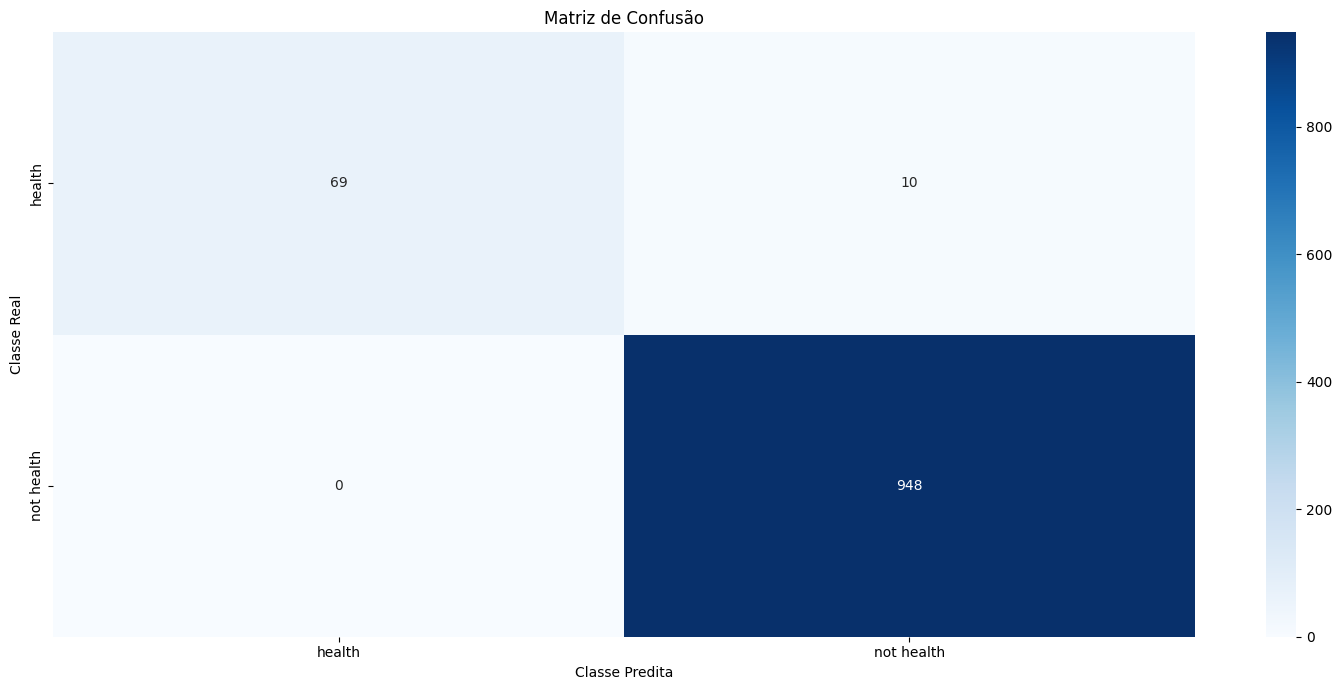

Accuracy: 99.03%
Precision: 100.00%
Recall: 87.34%
F1 Score: 93.24%
              precision    recall  f1-score   support

      health       1.00      0.87      0.93        79
  not health       0.99      1.00      0.99       948

    accuracy                           0.99      1027
   macro avg       0.99      0.94      0.96      1027
weighted avg       0.99      0.99      0.99      1027

7 features analisadas


In [35]:
#for n in range(1,41):
n=7
df_features_resposta = gerar_features_resposta_treino(n)
df_features_resposta_t = gerar_features_resposta_teste(n) #melhor = 7
evaluate_model(df_features_resposta_t)

Pedido para iterar a função acima e plotar

In [29]:
#evaluate_model_f1score(df_features_resposta)

## DEMONSTRAÇÃO OVERFITTING APÓS 10 FEATURES
Não vou otimizar o número de features, foi escolhido como escopo do projeto 10 features e vou manter
- posso comentar que idealmente usaria um conjunto de validação para escolher o número ideal de features

Melhor resultado encontrado foi o f1-score para 10 features = 63%

[0.22695035460992907, 0.4664723032069971, 0.4790419161676647, 0.4790419161676647, 0.6557377049180327, 0.6837606837606837, 1.0, 1.0, 1.0]
[0.22451994091580502, 0.33557046979865773, 0.33860045146726864, 0.33860045146726864, 0.5584905660377358, 0.5702479338842975, 0.9324324324324325, 0.9251700680272108, 0.9251700680272108]


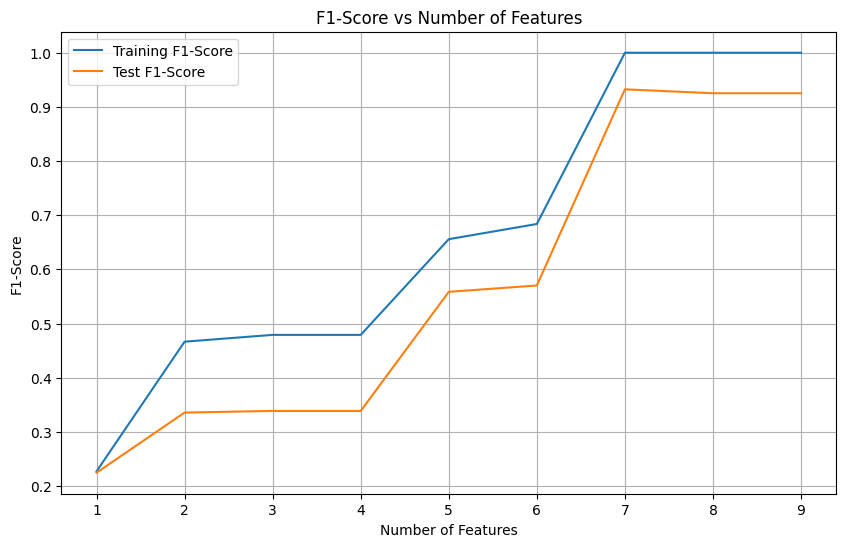

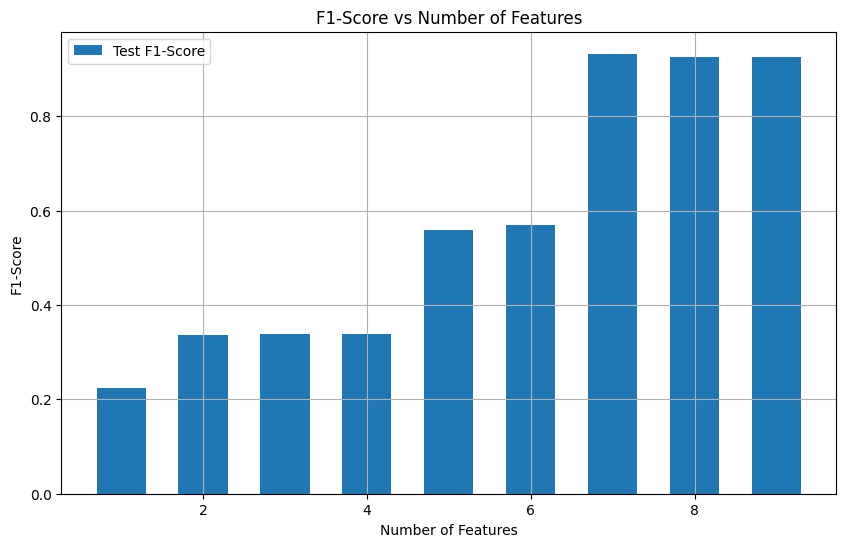

In [36]:
# Function to evaluate model and return F1-score
def evaluate_model_f1score(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, pos_label='health') #revisar isso  se não é 'not health'
    
    return f1

# Loop through number of features from 1 to 40 and evaluate F1-scores
def evaluate_feature_selection():
    num_features_range = range(1, 10)
    f1_scores_train = []
    f1_scores_test = []

    for num_features in num_features_range:
        # Get training and test data
        df_features_resposta = gerar_features_resposta_treino(num_features)  # Replace with your actual training data function
        df_features_resposta_t = gerar_features_resposta_teste(num_features)  # Replace with your actual test data function
        
        # Evaluate the model on training data
        f1_train = evaluate_model_f1score(df_features_resposta)
        f1_scores_train.append(f1_train)
        
        # Evaluate the model on test data
        f1_test = evaluate_model_f1score(df_features_resposta_t)
        f1_scores_test.append(f1_test)
    print(f1_scores_train)
    print(f1_scores_test)
    
    # Plotting F1-Score comparison
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_range, f1_scores_train, label='Training F1-Score')
    plt.plot(num_features_range, f1_scores_test, label='Test F1-Score')
    plt.xlabel('Number of Features')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.bar(num_features_range, f1_scores_test, width=0.6, label='Test F1-Score')
    plt.xlabel('Number of Features')
    plt.ylabel('F1-Score')
    plt.title('F1-Score vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Example usage
evaluate_feature_selection()

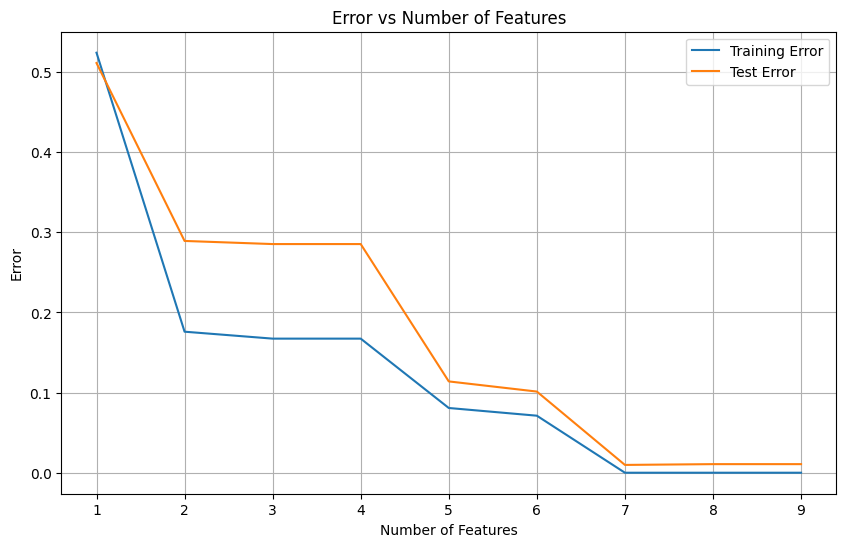

In [31]:
def evaluate_model_error(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Calculate error
    error = 1 - np.trace(cm) / np.sum(cm)
    
    return error

# Loop through number of features from 1 to 40 and evaluate errors
def evaluate_feature_selection_error():
    num_features_range = range(1, 10)
    errors_train = []
    errors_test = []

    for num_features in num_features_range:
        # Get training and test data
        df_features_resposta = gerar_features_resposta_treino(num_features)  # Replace with your actual training data function
        df_features_resposta_t = gerar_features_resposta_teste(num_features)  # Replace with your actual test data function
        
        # Ensure the returned DataFrame is not None
        if df_features_resposta is None or df_features_resposta_t is None:
            print(f"executar_teste returned None for num_features={num_features}")
            continue
        
        # Evaluate the model on training data
        error_train = evaluate_model_error(df_features_resposta)
        errors_train.append(error_train)
        
        # Evaluate the model on test data
        error_test = evaluate_model_error(df_features_resposta_t)
        errors_test.append(error_test)

    # Plotting error comparison
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_range, errors_train, label='Training Error')
    plt.plot(num_features_range, errors_test, label='Test Error')
    plt.xlabel('Number of Features')
    plt.ylabel('Error')
    plt.title('Error vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
evaluate_feature_selection_error()

[0.128, 0.3041825095057034, 0.31496062992125984, 0.31496062992125984, 0.4878048780487805, 0.5194805194805194, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.12709030100334448, 0.20380434782608695, 0.20604395604395603, 0.20604395604395603, 0.3978494623655914, 0.4233128834355828, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


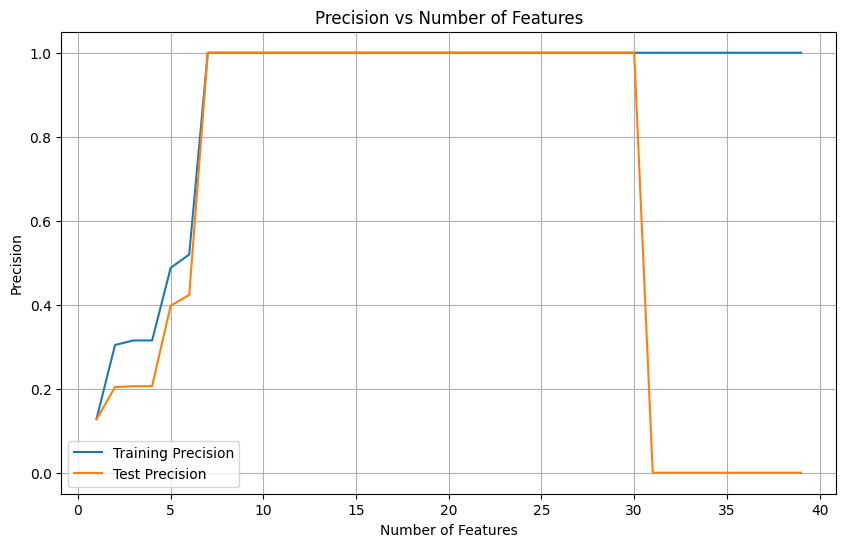

In [32]:

# Function to evaluate model and return Precision
def evaluate_model_precision(features_resposta):
    y_true = features_resposta['Fault']
    y_pred = features_resposta['Resposta SE']
    labels = ['health', 'not health']
    
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Calculate Precision
    precision = precision_score(y_true, y_pred, pos_label='health')  # Ensure 'health' is the correct positive label
    
    return precision

# Loop through number of features from 1 to 40 and evaluate Precision scores
def evaluate_feature_selection_precision():
    num_features_range = range(1, 40)
    precision_scores_train = []
    precision_scores_test = []

    for num_features in num_features_range:
        # Get training and test data
        df_features_resposta = gerar_features_resposta_treino(num_features)  # Replace with your actual training data function
        df_features_resposta_t = gerar_features_resposta_teste(num_features)  # Replace with your actual test data function
        
        # Evaluate the model on training data
        precision_train = evaluate_model_precision(df_features_resposta)
        precision_scores_train.append(precision_train)
        
        # Evaluate the model on test data
        precision_test = evaluate_model_precision(df_features_resposta_t)
        precision_scores_test.append(precision_test)
    
    print(precision_scores_train)
    print(precision_scores_test)
    
    # Plotting Precision Score comparison
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_range, precision_scores_train, label='Training Precision')
    plt.plot(num_features_range, precision_scores_test, label='Test Precision')
    plt.xlabel('Number of Features')
    plt.ylabel('Precision')
    plt.title('Precision vs Number of Features')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Example usage
evaluate_feature_selection_precision()